<a href="https://colab.research.google.com/github/centuryglass/QtGLID3/blob/colab-refactor/colabFiles/GLID_3_XL_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLID-3-XL Inpainting/Image Generation

Run all steps in order without changes to test inpainting.  Update the variables in the first two steps to alter inpainting/image generation to fit your needs. Not all options are fully tested, but basic inpainting and image generation should work.


---

## Define image generation variables:
If you've already run every step in this notebook, you can change these values, then immediately re-run the image generation step to get new results 
with the updated settings:

In [12]:
# Generated images should match this description:
prompt='godzilla'

# Generated images should not match this description:
negative='night sky'

# Image file prefix:
prefix='glid3xl'

# Source image to use, if inpainting:
edit='https://github.com/centuryglass/glid-3-xl-expanded-inpainting/raw/colab-refactor/examples/edit.png'

# Image mask covering the areas that should be edited:
mask='https://github.com/centuryglass/glid-3-xl-expanded-inpainting/raw/colab-refactor/examples/mask.png'

# batch_size*num_batches inpainting sample images will be generated:
batch_size=3
num_batches=3

# init_image doesn't work with inpainting, leave as None unless you're going
# to update the notebook to use the standard image generation model:
init_image=None

# Image dimensions:
# Values other than 256,256 are unlikely to work well, especially for
# inpainting:
width=256
height=256

# Number of diffusion steps (defaults to 27 if set to None):
steps=None

# Higher values of guidance_scale adhere more closely to the prompt, but are
# less likely to produce interesting variations:
guidance_scale=5.0

# Whether CLIP should rank the images based on the prompt and negative:
clip_score=True

# Define model init settings:
If you change any of these values, you will need to re-run the 
"load all models" step (and possibly the "download required models" step)
to apply changes.

In [20]:
# Name of the primary model to use:
model_path = 'inpaint.pt'
# LAION-AI has excellent fine-tuned inpainting models that you can also use:
# - "ongo.pt": Trained on WikiArt, produces better artistic results.
# - "erlich.pt": Trained on logos.
# "finetune.pt" and "diffusion.pt" are also valid options. Those models are for
# regular image generation, not inpainting, so 'edit' and 'mask' will be unset
# if these models are used.
if model_path == 'finetune.pt' or model_path == 'diffusion.pt':
  edit=None
  mask=None

# Set to true to load models from your google drive instead of downloading:
use_google_drive=True
drive_model_dir="inpainting"
# If you're using google drive and haven't already uploaded models, set this
# to True and models will be uploaded to Drive so they can be loaded more
# quickly next time.  This will require something like 6-10 GB of available
# storage in Drive, depending on what models you're using.
save_missing_models_to_drive=False

# Set clip_guidance to true for greater accuracy but reduced speed.
# This requires Colab Pro, free Colab instances don't have enough GPU memory.
clip_guidance=False
clip_guidance_scale=150

# Set clip model to use, valid options are RN50, RN101, RN50x4, RN50x16, 
# RN50x64, ViT-B/32, ViT-B/16, ViT-L/14. Most of these are not working when
# clip_guidance is true, see test results below.
clip_model_name = 'ViT-L/14'

################################################################################
# CLIP model test results (with clip_guidance=True)
################################################################################
#   ViT-L/14:  On free-tier colab, CUDA runs out of memory during image
#              generation
#
#   ViT-B/32:  RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x512
#              and 768x1280)
#
#   ViT-B/16:  RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x512
#              and 768x1280)
#
#   RN50:      RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x1024
#              and 768x1280)
#
#   RN101:     RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x512
#              and 768x1280)
#
#   RN50x4:    RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x640
#              and 768x1280)
#
#   RN50x16:   On free-tier colab, CUDA runs out of memory during image
#              generation
#
#   RN50x64:   RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x1024
#              and 768x1280)
################################################################################

# Other params:
# Changing these will subtly alter the image generation process in ways I
# haven't bothered to identify yet. You should just be able to leave them as-is
# and still get good results:
cutn=16
# At most one of these should be used:
ddim=False
ddpm=False



---


# Initial loading steps:
Unless you change model settings or restart the session, you should only need to run these steps once.

In [21]:
# install dependencies:
import os, sys
%cd /content
!pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops ftfy regex tqdm transformers
!pip install git+https://github.com/openai/CLIP.git
for compVisDep in ['taming-transformers', 'latent-diffusion']:
  if not os.path.exists(compVisDep):
    !git clone https://github.com/CompVis/{compVisDep}.git
    !pip install -e {compVisDep}
    sys.path.append(f'/content/{compVisDep}')
if not os.path.exists('glid-3-xl-expanded-inpainting'):
  !git clone https://github.com/centuryglass/glid-3-xl-expanded-inpainting
%cd glid-3-xl-expanded-inpainting
!git fetch origin
!git checkout origin/colab-refactor
!pip install -e .

# download required models:
import os
drive_path='/content/gdrive/MyDrive/'
if use_google_drive:
    from google.colab import drive
    drive.mount('/content/gdrive')
    if drive_model_dir:
      drive_path = drive_path + drive_model_dir + '/'
      if not os.path.exists(drive_path):
        os.mkdir(drive_path)
for model in ['bert.pt', 'kl-f8.pt', model_path]:
    if use_google_drive and not os.path.isfile(model) and os.path.isfile(f'{drive_path}{model}'):
      !cp '{drive_path}{model}' .
    if not os.path.isfile(model):
      if model == "erlich.pt":
        !wget --continue -O erlich.pt https://huggingface.co/laion/erlich/resolve/main/model/ema_0.9999_120000.pt
      elif model == "ongo.pt":
        !wget https://huggingface.co/laion/ongo/resolve/main/ongo.pt
      else:  
        !wget 'https://dall-3.com/models/glid-3-xl/{model}'
    if os.path.isfile(model):
      print(f"model file '{model}' obtained.")
      if use_google_drive and save_missing_models_to_drive and not os.path.isfile(f'{drive_path}{model}'):
        !cp '{model}' '{drive_path}{model}'
        if os.path.isfile(f'{drive_path}{model}'):
          print(f'saved {model} to google drive')
        else:
          print(f'error: unable to save {model} to google drive')
    else:
      print(f"error: failed to get required model file '{model}'!")

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yklrtvyt
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-yklrtvyt
/content/glid-3-xl-expanded-inpainting
HEAD is now at 630ff08 initial docs, sketch inputs, fixes
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/glid-3-xl-expanded-inpainting
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Can't uninstall 'guided-diffusion'. No files were found to uninstall.
  Running setup.py develop for guided-diffusion
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
model file 'bert.pt' obtained.
model file 'kl-f8.pt' obtained.
model file 'ongo.pt' obtained.
saved ongo.pt to google dr

In [15]:
# If models are already loaded, they'll need to be unloaded first before
# re-running, or colab will run out of memory on free tier:
import torch
import gc
model_params = None
model = None
diffusion = None
ldm = None
bert = None
clip_model = None
clip_preprocess = None
normalize = None
device = torch.device('cuda:0')
gc.collect()
with torch.no_grad():
  torch.cuda.empty_cache()
# GPU memory doesn't seem to get cleared completely, and will run out
# eventually if models are reloaded multiple times without restarting the
# runtime.

# Load all models:
from startup.load_models import loadModels
model_params, model, diffusion, ldm, bert, clip_model, clip_preprocess, normalize = loadModels(
    device,
    model_path=model_path,
    clip_model_name=clip_model_name,
    steps=steps,
    clip_guidance=clip_guidance,
    ddpm=ddpm,
    ddim=ddim)

loaded and configured primary model from erlich.pt
loaded and configured latent diffusion model from kl-f8.pt
loaded and configured BERT model from bert.pt
loaded and configured CLIP model from ViT-L/14


# Image Generation:
You can re-run this step as many times as you want to continue producing new images. Each run will overwrite the images from the previous run, so make sure to download any that you want to keep first.

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

glid3xl_0.249_00006.png


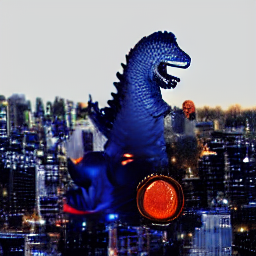

glid3xl_0.267_00002.png


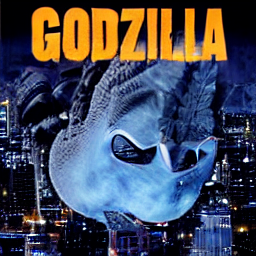

glid3xl_0.247_00003.png


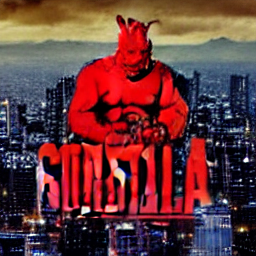

glid3xl_0.254_00007.png


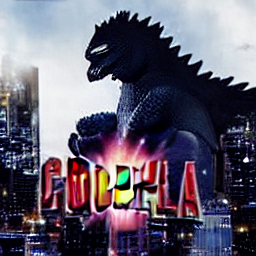

glid3xl_0.256_00008.png


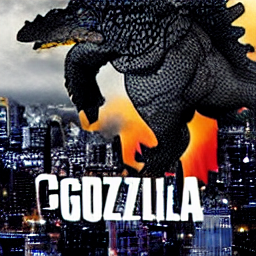

glid3xl_0.250_00004.png


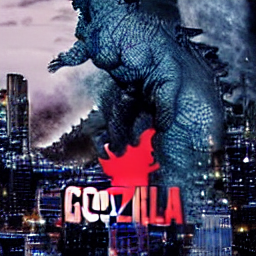

glid3xl_0.266_00005.png


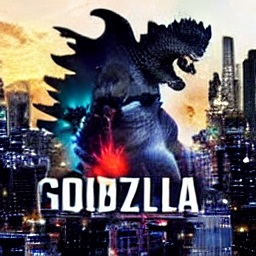

glid3xl_0.246_00001.png


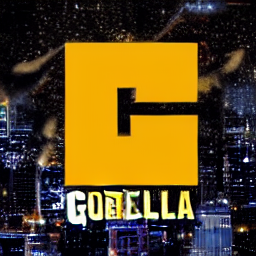

glid3xl_0.261_00000.png


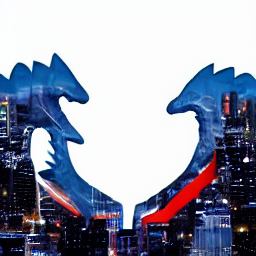

In [16]:
# prepare sample generation function, generate images:
from startup.create_sample_function import createSampleFunction
sample_fn, clip_score_fn = createSampleFunction(
        device,
        model,
        model_params,
        bert,
        clip_model,
        clip_preprocess,
        ldm,
        diffusion,
        normalize,
        image=init_image,
        edit=edit,
        mask=mask,
        prompt=prompt,
        negative=negative,
        guidance_scale=guidance_scale,
        batch_size=batch_size,
        width=width,
        height=height,
        cutn=cutn,
        edit_width=256,
        edit_height=256,
        edit_x=0,
        edit_y=0,
        clip_guidance=clip_guidance,
        clip_guidance_scale=clip_guidance_scale,
        skip_timesteps=0,
        ddpm=ddpm,
        ddim=ddim)  

from PIL import Image
import os
from torchvision.transforms import functional as TF
import numpy as np
from startup.utils import *
from startup.ml_utils import *
from startup.generate_samples import generateSamples
!rm -rf output output_npy
!mkdir output output_npy
def save_sample(i, sample, clip_score_fn=None):
    for k, image in enumerate(sample['pred_xstart'][:batch_size]):
        image /= 0.18215
        im = image.unsqueeze(0)
        out = ldm.decode(im)

        npy_filename = f'output_npy/{i * batch_size + k:05}.npy'
        with open(npy_filename, 'wb') as outfile:
            np.save(outfile, image.detach().cpu().numpy())

        out = TF.to_pil_image(out.squeeze(0).add(1).div(2).clamp(0, 1))

        filename = f'output/{i * batch_size + k:05}.png'
        out.save(filename)

        if clip_score:
          import clip
          text = clip.tokenize([text]*batch_size, truncate=True).to(device)
          text_clip_blank = clip.tokenize([negative]*batch_size, truncate=True).to(device)
          # clip context
          text_emb_clip = clip_model.encode_text(text)
          text_emb_clip_blank = clip_model.encode_text(text_clip_blank)
          image_emb = clip_model.encode_image(clip_preprocess(out).unsqueeze(0).to(device))
          image_emb_norm = image_emb / image_emb.norm(dim=-1, keepdim=True)
          text_emb_norm = text_emb_clip[0] / text_emb_clip[0].norm(dim=-1, keepdim=True)
          similarity = torch.nn.functional.cosine_similarity(image_emb_norm, text_emb_norm, dim=-1)

          final_filename = f'output/{similarity.item():0.3f}_{i * batch_size + k:05}.png'
          os.rename(filename, final_filename)

          npy_final = f'output_npy/{similarity.item():0.3f}_{i * batch_size + k:05}.npy'
          os.rename(npy_filename, npy_final)
gc.collect()
generateSamples(device,
                ldm,
                diffusion,
                sample_fn,
                getSaveFn(prefix, batch_size, ldm, clip_model, clip_preprocess, device),
                batch_size,
                num_batches,
                width=width,
                height=height,
                init_image=init_image,
                clip_score_fn=clip_score_fn if clip_score else None)

# View results:
import cv2
from google.colab.patches import cv2_imshow
for sample in os.listdir('output'):
  if clip_score:
    print(sample)
  img = cv2.imread(f'output/{sample}', cv2.IMREAD_UNCHANGED)
  cv2_imshow(img)

In [17]:
# Optional: run this to download all results as a zip file.
!zip -r glid-3-xl-results.zip output
from google.colab import files
files.download("glid-3-xl-results.zip")

updating: output/ (stored 0%)
updating: output/glid3xl_0.266_00005.png (deflated 0%)
  adding: output/glid3xl_0.249_00006.png (deflated 0%)
  adding: output/glid3xl_0.267_00002.png (deflated 0%)
  adding: output/glid3xl_0.247_00003.png (deflated 0%)
  adding: output/glid3xl_0.254_00007.png (deflated 0%)
  adding: output/glid3xl_0.256_00008.png (deflated 0%)
  adding: output/glid3xl_0.250_00004.png (deflated 0%)
  adding: output/glid3xl_0.246_00001.png (deflated 0%)
  adding: output/glid3xl_0.261_00000.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>